In [70]:
import sys
import subprocess

#import pkg_resources
#required = {'harmonypy','sklearn','scanpy','pandas', 'numpy', 'bbknn', 'scipy', 'matplotlib', 'seaborn' ,'scipy'}
#installed = {pkg.key for pkg in pkg_resources.working_set}
#missing = required - installed
#if missing:
#    print("Installing missing packages:" )
#    print(missing)
#    python = sys.executable
#    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

%matplotlib inline
from collections import Counter
from collections import defaultdict
import scanpy as sc
import pandas as pd
import pickle as pkl
import numpy as np
from bbknn import bbknn
import scipy
import matplotlib.pyplot as plt
import re
import glob
import os
import sys
from numpy import cov
import scipy.cluster.hierarchy as spc
import seaborn as sns; sns.set(color_codes=True)
from sklearn.linear_model import LogisticRegression
import sklearn
import harmonypy as hm
from pathlib import Path

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=300, color_map='viridis')
plt.rcParams['figure.figsize'] = [15, 15]

In [71]:
col_pal = [
    '#ff0000',
    '#94BFB1',
    '#B49EC8',
    '#E0EE70',
    '#EE943E',
    '#4C7BAB',
    '#E78AB8',
    '#AFBFCC',
    '#814F75',
    "#FFFF00", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6", "#A30059",
    "#FFDBE5", "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87",
    "#5A0007", "#809693", "#6A3A4C", "#1B4400", "#4FC601", "#3B5DFF"
]

In [72]:
run_name = 'YS_fliv_progen_trajectory_with_HE_290921'
save_loc = '/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_090321_notebooks/YS_Reprocess_250721_updates/FDG_FIG2/'
Object = '/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/A4_V7_Combined_YS_Fliver_20210914.h5ad'
save_path = "/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_090321_notebooks/YS_Reprocess_250721_updates/LR_YS_LIV"

# Required: Name of first object
data2 = "_ys"
# Provide categorical to join between datasets
cat2 = "cell.labels"

# Required: Name of second object
data1 = "_fliv"
# Provide categorical to join between datasets
cat1 = "cell.labels"

In [73]:
import os
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
adata = sc.read(Object)
adata.obs.columns

Index(['cell.labels', 'stage', 'lanes', 'sex', 'sort.ids', 'fetal.ids',
       'component', 'broad_cell.labels', 'sequencing.type', 'orig.dataset',
       'broad_cell_labels_organ', 'tissue', 'tissue_fetal_id'],
      dtype='object')

# Update adata metadata

In [104]:
obs = pd.read_csv('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_090321_notebooks/YS_Reprocess_250721_updates/Combined_YS_Fliver_meta_20210929.csv',index_col=0)
adata.obs = obs

In [105]:
common_cat = "corr_concat" 
adata.obs[common_cat] = "corr_concat"
adata.obs.loc[adata.obs['tissue'].isin(['YS']),common_cat] = adata.obs.loc[adata.obs['tissue'].isin(['YS']),cat1].astype(str) + data2
adata.obs.loc[adata.obs['tissue'].isin(['Liver']),common_cat] = adata.obs.loc[adata.obs['tissue'].isin(['Liver']),cat2].astype(str) + data1

# Mod both data manually

In [83]:
adata.obs.columns

Index(['cell.labels', 'stage', 'lanes', 'sex', 'sort.ids', 'fetal.ids',
       'component', 'broad_cell.labels', 'sequencing.type', 'orig.dataset',
       'broad_cell_labels_organ', 'tissue', 'corr_concat'],
      dtype='object')

In [84]:
adata.obs["lr_batch"]  = adata.obs["tissue"].astype(str) + '_' +  adata.obs['fetal.ids'].astype(str)

In [85]:
list(adata.obs["lr_batch"].unique())

['YS_Wang_CS10',
 'YS_Wang_CS11',
 'YS_F32',
 'YS_F35',
 'YS_F37',
 'YS_F61',
 'YS_F79',
 'YS_F80',
 'Liver_F61',
 'Liver_F35',
 'Liver_F32']

In [106]:
adata.obs

,cell.labels,stage,lanes,sex,sort.ids,fetal.ids,component,broad_cell.labels,sequencing.type,orig.dataset,broad_cell_labels_organ,tissue,corr_concat
Wang_et_al_AAACCTGAGACCTTTG_1,Sinusoidal_EC,CS10,Wang_CS10,Male,Total,Wang_CS10,Membrane,Endothelium,TBC,Wang_et_al_Cell_Stem Cell_2021,Endothelium_ys,YS,Sinusoidal_EC_ys
Wang_et_al_AAACCTGCACCTATCC_1,MEMP,CS10,Wang_CS10,Male,Total,Wang_CS10,Membrane,Progenitors,TBC,Wang_et_al_Cell_Stem Cell_2021,Progenitors_ys,YS,MEMP_ys
Wang_et_al_AAACCTGCACTTAAGC_1,HSPC_1,CS10,Wang_CS10,Male,Total,Wang_CS10,Membrane,Progenitors,TBC,Wang_et_al_Cell_Stem Cell_2021,Progenitors_ys,YS,HSPC_1_ys
Wang_et_al_AAACCTGGTAACGACG_1,Erythroid,CS10,Wang_CS10,Male,Total,Wang_CS10,Membrane,Erythroid,TBC,Wang_et_al_Cell_Stem Cell_2021,Erythroid_ys,YS,Erythroid_ys
Wang_et_al_AAACCTGGTCAAAGAT_1,Erythroid,CS10,Wang_CS10,Male,Total,Wang_CS10,Membrane,Erythroid,TBC,Wang_et_al_Cell_Stem Cell_2021,Erythroid_ys,YS,Erythroid_ys
...,...,...,...,...,...,...,...,...,...,...,...,...,...
F32_Liver_CD45-_FCAImmP7316895_TTTGTCAAGGTGCACA,Early_Erythroid,F32,FCAImmP7316895,NaN,CD45-,F32,NaN,Erythroid,NaN,NaN,Erythroid_fliv,Liver,Early_Erythroid_fliv
F32_Liver_CD45-_FCAImmP7316895_TTTGTCAAGTACGCCC,Hepatocyte,F32,FCAImmP7316895,NaN,CD45-,F32,NaN,Hepatocyte,NaN,NaN,Hepatocyte_fliv,Liver,Hepatocyte_fliv
F32_Liver_CD45-_FCAImmP7316895_TTTGTCACAAGCGATG,Early_Erythroid,F32,FCAImmP7316895,NaN,CD45-,F32,NaN,Erythroid,NaN,NaN,Erythroid_fliv,Liver,Early_Erythroid_fliv
F32_Liver_CD45-_FCAImmP7316895_TTTGTCACACTAGTAC,Early_Erythroid,F32,FCAImmP7316895,NaN,CD45-,F32,NaN,Erythroid,NaN,NaN,Erythroid_fliv,Liver,Early_Erythroid_fliv


In [86]:
list(adata.obs[common_cat].unique())

['Sinusoidal_EC_ys',
 'MEMP_ys',
 'HSPC_1_ys',
 'Erythroid_ys',
 'Endoderm_ys',
 'Immature_EC_ys',
 'Macrophage_ys',
 'MK_ys',
 'Early_Erythroid_ys',
 'Lymphoid_progenitor_ys',
 'Mesothelium_ys',
 'Prolif_Sinusoidal_EC_ys',
 'Fibroblast_ys',
 'HSPC_2_ys',
 'AEC_ys',
 'Mast_cell_ys',
 'MOP_ys',
 'DC2_ys',
 'CMP_ys',
 'DC_precursor_ys',
 'HE_ys',
 'Monocyte_ys',
 'LMPP_ys',
 'Neutrophil_precursor_ys',
 'Microglia_ys',
 'Smooth_Muscle_ys',
 'Promonocyte_ys',
 'Eo_Baso_Mast_precursor_ys',
 'ILC_precursor_ys',
 'Pre_Macrophage_ys',
 'VWF_EC_ys',
 'Eo_Basophil_ys',
 'Prolif_AEC_ys',
 'NK_ys',
 'Monocyte_Macrophage_ys',
 'MPP_fliv',
 'Kupffer_cell_1_fliv',
 'Kupffer_cell_2_fliv',
 'Hepatocyte_fliv',
 'Endothelium_fliv',
 'Early_Erythroid_fliv',
 'MEMP_fliv',
 'MLP_fliv',
 'MK_fliv',
 'Erythroid_fliv',
 'DC3_fliv',
 'DC2_fliv',
 'Monocyte_fliv',
 'HSC_fliv',
 'Promyelocyte_fliv',
 'Mast_cell_fliv',
 'DC1_fliv',
 'CMP_fliv',
 'Pre_pro_B_progenitor_fliv',
 'Embryonic_Erythroid_fliv',
 'MOP_fliv'

In [43]:
keep = [
'Monocyte_fliv',
 'MOP_ys',
 'Monocyte_ys',
 'Promonocyte_ys',
'Monocyte_Macrophage_ys',
'Pre_Macrophage_ys',]

In [44]:
adata = adata[adata.obs[common_cat].isin(keep)]

In [45]:
adata.obs['stage_groups'] = adata.obs['corr_concat'][:]
adata.obs['stage_groups'] = adata.obs['stage_groups'].astype(str)
stages= ['CS7','CS10', 'CS11', 'CS22', 'CS23', 'CS14', 'CS18', 'CS15']
groups = ['CS7','CS10_11', 'CS10_11', 'CS22_23', 'CS22_23', 'CS14_15', 'CS18', 'CS14_15']
dic = dict(zip(stages,groups))
#YS_HSC.obs['stage_groups'] = YS_HSC.obs['stage'].map(dic)
adata.obs.loc[adata.obs['stage'].isin(stages),'stage_groups'] = adata.obs['stage'].map(dic)
adata.obs['stage_groups'].unique()

<ipython-input-45-d328f87f9c8e>:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['stage_groups'] = adata.obs['corr_concat'][:]


array(['CS10_11', 'CS22_23', 'CS14_15', 'CS18'], dtype=object)

In [46]:
norm_count = ((adata.obs.groupby(['stage_groups',common_cat], observed=True).count()).iloc[:,1]).reset_index()
norm_count.columns = ['stage_groups','is_key','stage']
norm_count

,stage_groups,is_key,stage
0,CS10_11,MOP_ys,10
1,CS10_11,Monocyte_ys,6
2,CS10_11,Pre_Macrophage_ys,24
3,CS10_11,Promonocyte_ys,8
4,CS14_15,MOP_ys,32
5,CS14_15,Monocyte_Macrophage_ys,49
6,CS14_15,Monocyte_ys,223
7,CS14_15,Pre_Macrophage_ys,14
8,CS14_15,Promonocyte_ys,40
9,CS18,MOP_ys,79


In [47]:
count1 = ((adata.obs.groupby(['stage_groups','corr_concat'], observed=False).count()).iloc[:,1]).reset_index()
count1.columns = ['stage_groups','is_key','stage']
count1['stage'] = count1['stage'].astype(int)
count1['stage'] = count1['stage'] + 1
count2 = count1[:]

for i in count1['stage_groups'].unique():
    for z in count1.index[count1['stage_groups'].isin([i])]:
        count2.loc[count2.index.isin([z]),'stage'] = (count1.loc[count1.index.isin([z]),'stage'] / sum(count1['stage'][count1['stage_groups'].isin([i])]))*100
#count2.set_index(['leiden_mono', 'corr_concat'], inplace=True)

In [48]:
count3 = count2[:]
count3

,stage_groups,is_key,stage
0,CS10_11,MOP_ys,21.153846
1,CS10_11,Monocyte_ys,13.461538
2,CS10_11,Pre_Macrophage_ys,48.076923
3,CS10_11,Promonocyte_ys,17.307692
4,CS14_15,MOP_ys,9.090909
5,CS14_15,Monocyte_Macrophage_ys,13.774105
6,CS14_15,Monocyte_ys,61.707989
7,CS14_15,Pre_Macrophage_ys,4.132231
8,CS14_15,Promonocyte_ys,11.294766
9,CS18,MOP_ys,22.988506


In [49]:
# count3= pd.read_csv('mono_mopo_counts.csv',index_col=None)
# count3

In [50]:
count3.to_csv('mono_mopo_counts.csv')

In [51]:
count3 
count3.set_index(['stage_groups','is_key'], inplace=True)
count3.iloc[:,0].T.unstack().plot(kind='bar', stacked=False)

<AxesSubplot:xlabel='stage_groups'>

In [52]:
keep2 = [
 'MOP_ys',
 'CMP_ys',
 'Monocyte_ys',
 'Promonocyte_ys','Monocyte_Macrophage_ys','Pre_Macrophage_ys',]

In [53]:
count3 = (count3.reset_index)

In [54]:
count2

,stage_groups,is_key,stage
0,CS10_11,MOP_ys,21.153846
1,CS10_11,Monocyte_ys,13.461538
2,CS10_11,Pre_Macrophage_ys,48.076923
3,CS10_11,Promonocyte_ys,17.307692
4,CS14_15,MOP_ys,9.090909
5,CS14_15,Monocyte_Macrophage_ys,13.774105
6,CS14_15,Monocyte_ys,61.707989
7,CS14_15,Pre_Macrophage_ys,4.132231
8,CS14_15,Promonocyte_ys,11.294766
9,CS18,MOP_ys,22.988506


In [55]:
count3= pd.read_csv('mono_mopo_counts.csv',index_col=None)
for i in count3['is_key'].unique():
    print(list(count3['stage'][count3['is_key'].isin([i])]))

[21.153846153846157, 9.090909090909092, 22.988505747126435, 21.428571428571427]
[13.461538461538462, 61.70798898071625, 41.95402298850575, 57.14285714285714]
[48.07692307692308, 4.132231404958678, 5.459770114942529]
[17.307692307692307, 11.294765840220386, 27.011494252873565, 14.285714285714285]
[13.774104683195592, 2.586206896551724, 7.142857142857142]


In [61]:
count3[count3['is_key'].isin(['Monocyte_Macrophage_ys'])]

,Unnamed: 0,stage_groups,is_key,stage
5,5,CS14_15,Monocyte_Macrophage_ys,13.774105
10,10,CS18,Monocyte_Macrophage_ys,2.586207
15,15,CS22_23,Monocyte_Macrophage_ys,7.142857


In [57]:
count4 = count3[count3['is_key'].isin(["True"])]
count4

,Unnamed: 0,stage_groups,is_key,stage


In [58]:
cmap =       {
 'HSPC_1': '#ff7f0e',
 'HSPC_2': '#279e68',
'CMP': '#1f77b4',
"MEMP":"#b87056",
"LMPP":"#7a2839",
"Lymphoid_progenitor":"#FFFF99",
 'MOP': '#d62728',
 'Promonocyte': '#aec7e8',
 'Monocyte_0': '#e377c2',
'Monocyte_ys_1'	:	"#AB0890",
'Monocyte_Macrophage': '#b5bd61',
 'Pre_Macrophage': '#17becf',
 'Macrophage': '#aa40fc',
 'Microglia': '#8c564b',}

<ipython-input-68-9d6514c6de29>:59: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=False)


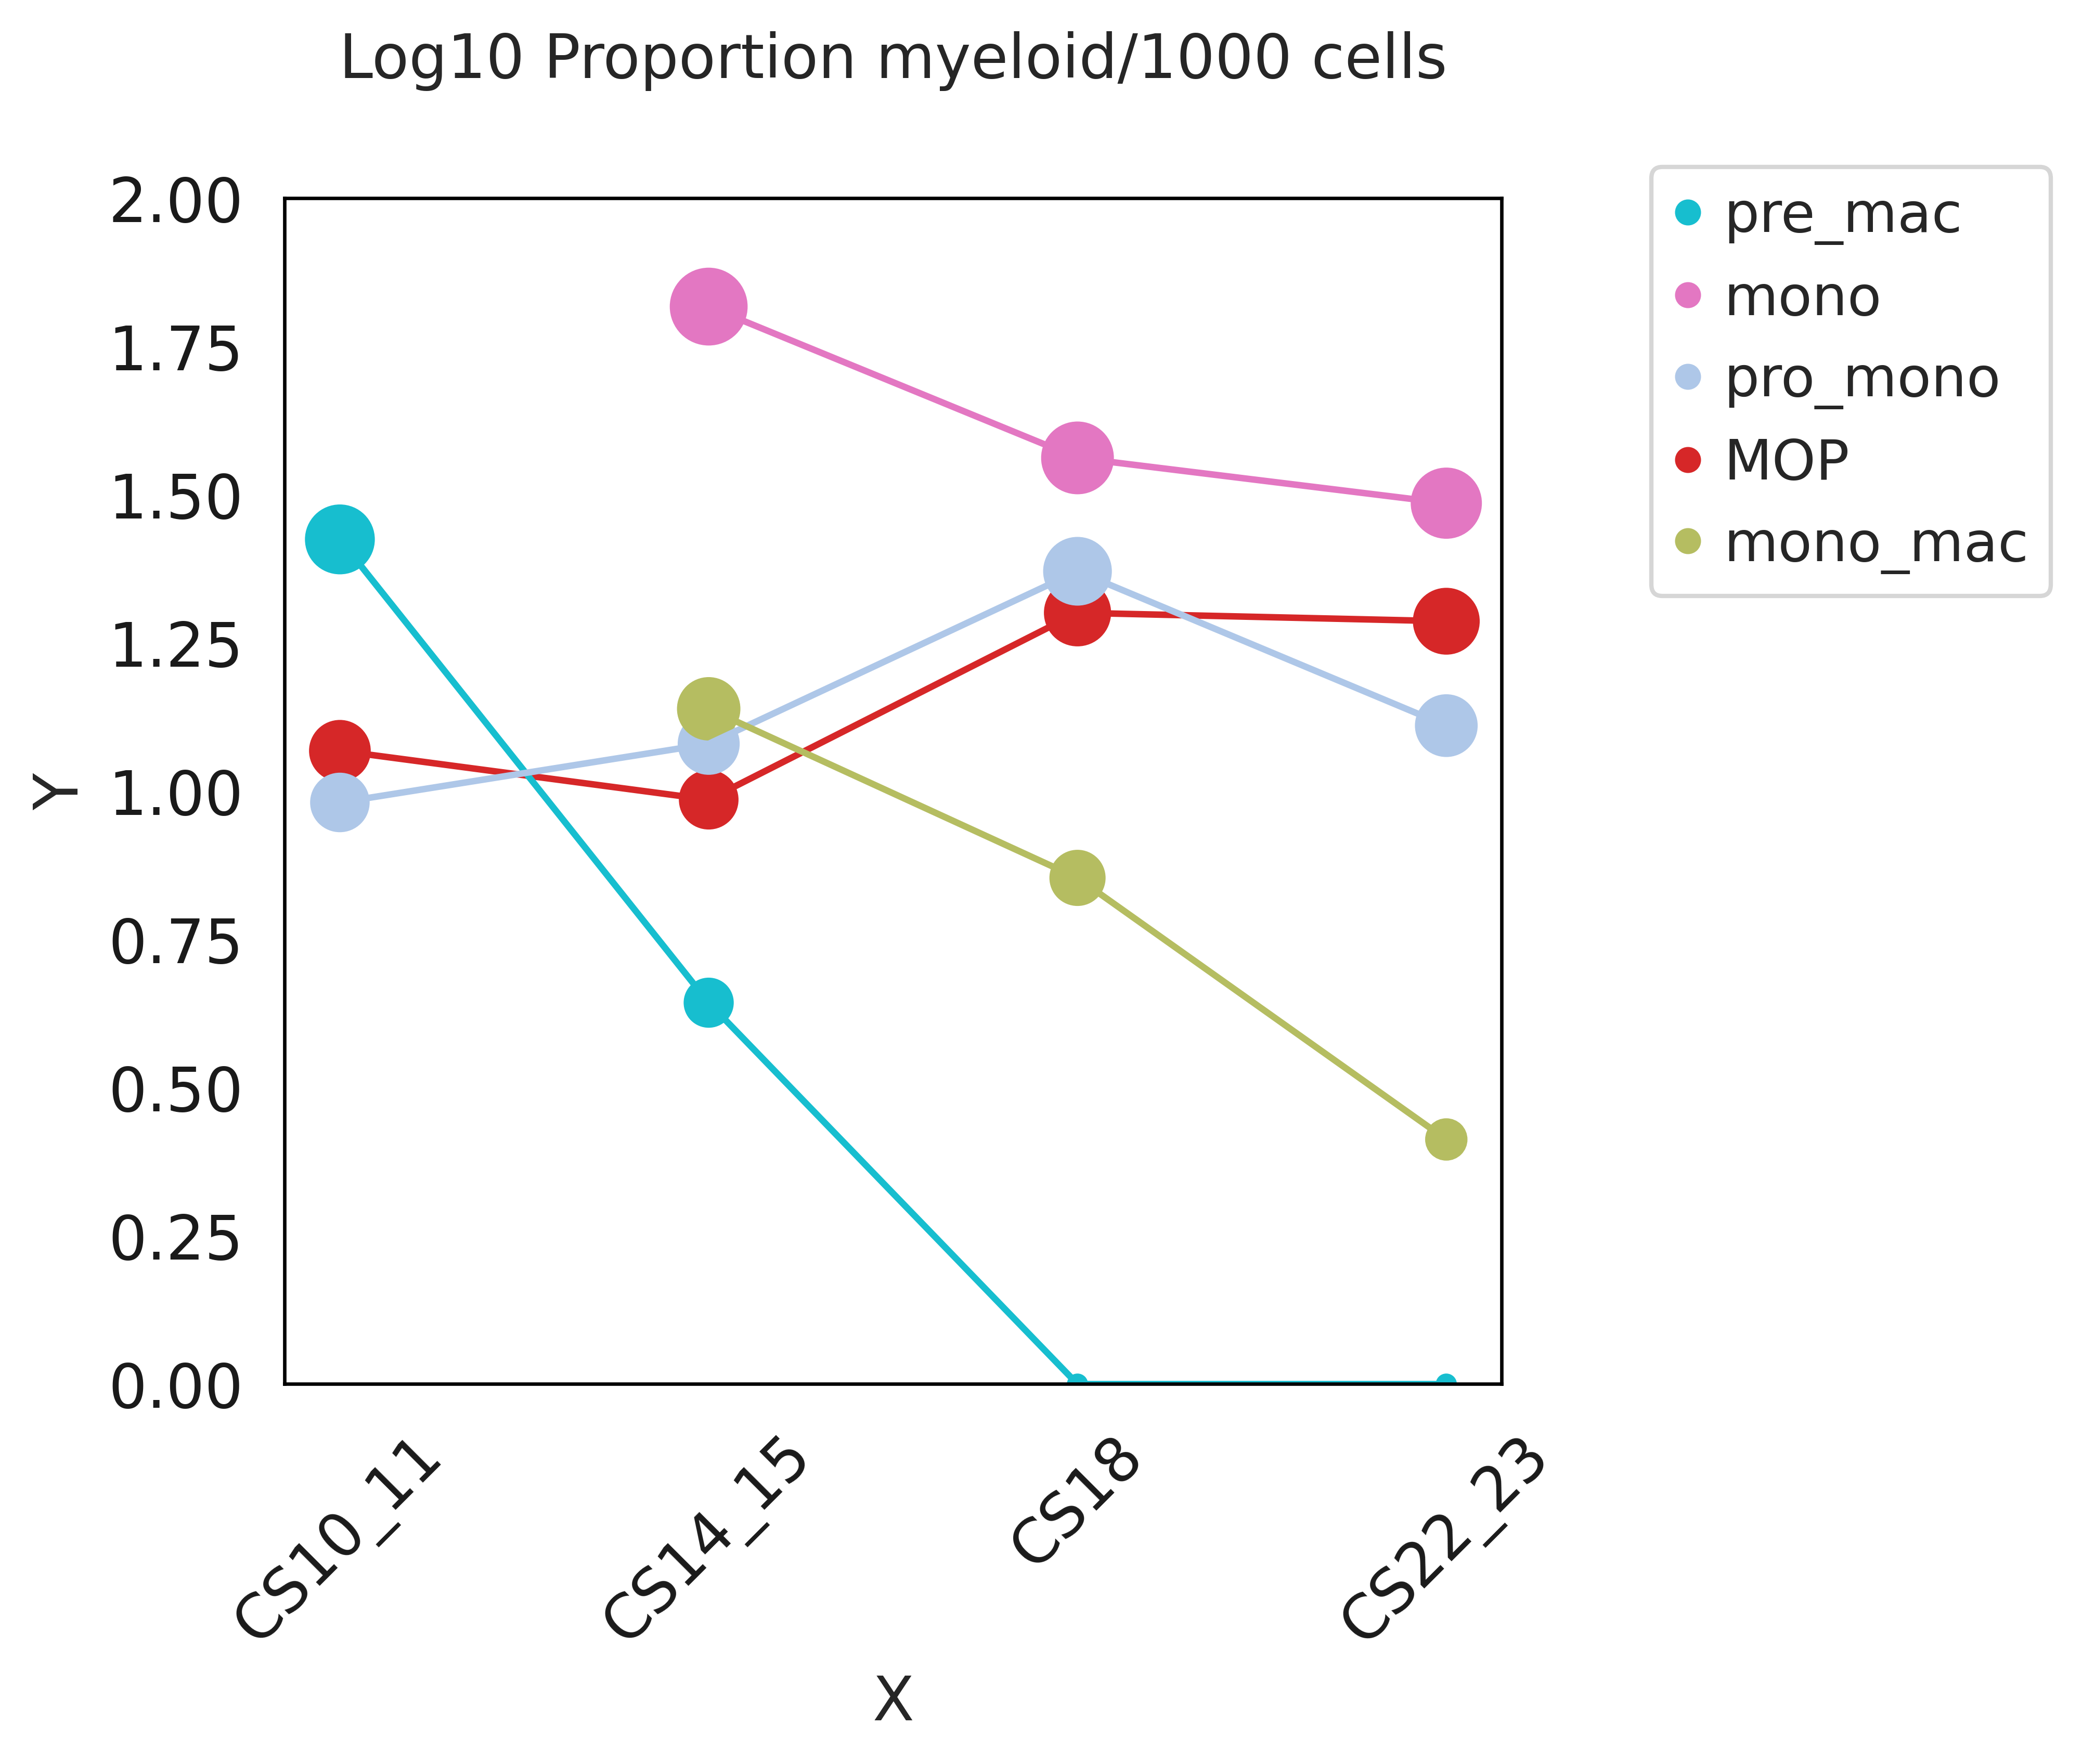

In [68]:
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure
figure(figsize=(5, 5), dpi= 300)

x=[ 'CS10_11', 'CS14_15', 'CS18', 'CS22_23']

ymin = 0
ymax = 2

x = np.array(x)
#ax = plt.scatter(x,y1,c="blue") #s = y1_size 
plt.scatter(x,y2,c="#d62728" ,s=(y2+0.1)*150, marker='o')
plt.plot(y2,c="#d62728",linestyle = None)
plt.scatter(x,y3_nan,c="#e377c2" ,s=(y3+0.1)*150, marker='o')
plt.plot(x,y3,c="#e377c2",linestyle = None)
plt.scatter(x,y4,c="#17becf", marker='o',s=(y4+0.1)*150 )
plt.plot(y4,c="#17becf",linestyle = None)
plt.scatter(x,y5,c="#aec7e8",s=(y5+0.1) *150,marker='o')
plt.plot(y5,c="#aec7e8",linestyle = None)

plt.scatter(x,y6,c="#b5bd61",s=(y6+0.1) *150,marker='o')
plt.plot(y6,c="#b5bd61",linestyle = None)


plt.xlabel("X")
plt.ylabel("Y")
plt.ylim(ymin, ymax)
plt.title("Log10 Proportion myeloid/1000 cells",y=1.08)
plt.grid(b=False)
#plt.legend()


import matplotlib.lines as mlines
premac = mlines.Line2D([], [], color='#17becf', marker='o', linestyle='None',
                          markersize=5, label='pre_mac')
mono = mlines.Line2D([], [], color='#e377c2', marker='o', linestyle='None',
                          markersize=5, label='mono')
promono = mlines.Line2D([], [], color='#aec7e8', marker='o', linestyle='None',
                          markersize=5, label='pro_mono')
mop = mlines.Line2D([], [], color='#d62728', marker='o', linestyle='None',
                          markersize=5, label='MOP')

mono_mac = mlines.Line2D([], [], color='#b5bd61', marker='o', linestyle='None',
                          markersize=5, label='mono_mac')

plt.legend(handles=[premac , mono,promono,mop,mono_mac ],bbox_to_anchor=(1.1, 1.05))


plt.xticks(rotation=45)

plt.savefig('./mono_mye_prop_mono_mac_1000cells.pdf', dpi=300,
        bbox_inches='tight', pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None
       )

# Dotplot

In [134]:
adata = sc.read('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/YS_panf_gonads_brain_eliv_combined_060922/A1_Vx_pan_organ_integrations/A1_V10_raw_scvi_YS_updated_panf_gonads_brain_build_donor_organ_corrected_031022.h5ad',backed = 'r')

In [127]:
# adata = adata[adata.obs['organ'].isin(['LI','YS'])]

In [136]:
keep = ['LI_MONOCYTE',
'YS_MONOCYTE_0',
'YS_MONOCYTE_1',
'YS_MOP',
'YS_PROMONOCYTE',
'YS_MONOCYTE_MACROPHAGE',
'YS_MACROPHAGE_PRE_MAC',
'YS_MACROPHAGE',
'YS_MACROPHAGE_MICROGLIA',
]
key = ['MONOCYTE',
'MONOCYTE_1',
'MONOCYTE_2',
'MOP',
'PROMONOCYTE',
'MONOCYTE_MACROPHAGE',
'MACROPHAGE_PRE_MAC',
'MACROPHAGE',
'MACROPHAGE_TREM2',
]
mapper = dict(zip(keep,key))
adata = adata[adata.obs['organ_lvl3'].isin(keep)].to_memory()

In [141]:
adata.obs['LVL_mono'] = adata.obs['organ_lvl3'].map(mapper)
adata.obs['LVL_mono'] = adata.obs['LVL_mono'].astype('category').cat.reorder_categories(key)

In [142]:
markers = ['ICAM3','SELL','PLAC8','LYZ','CD14','S100A8','S100A9']

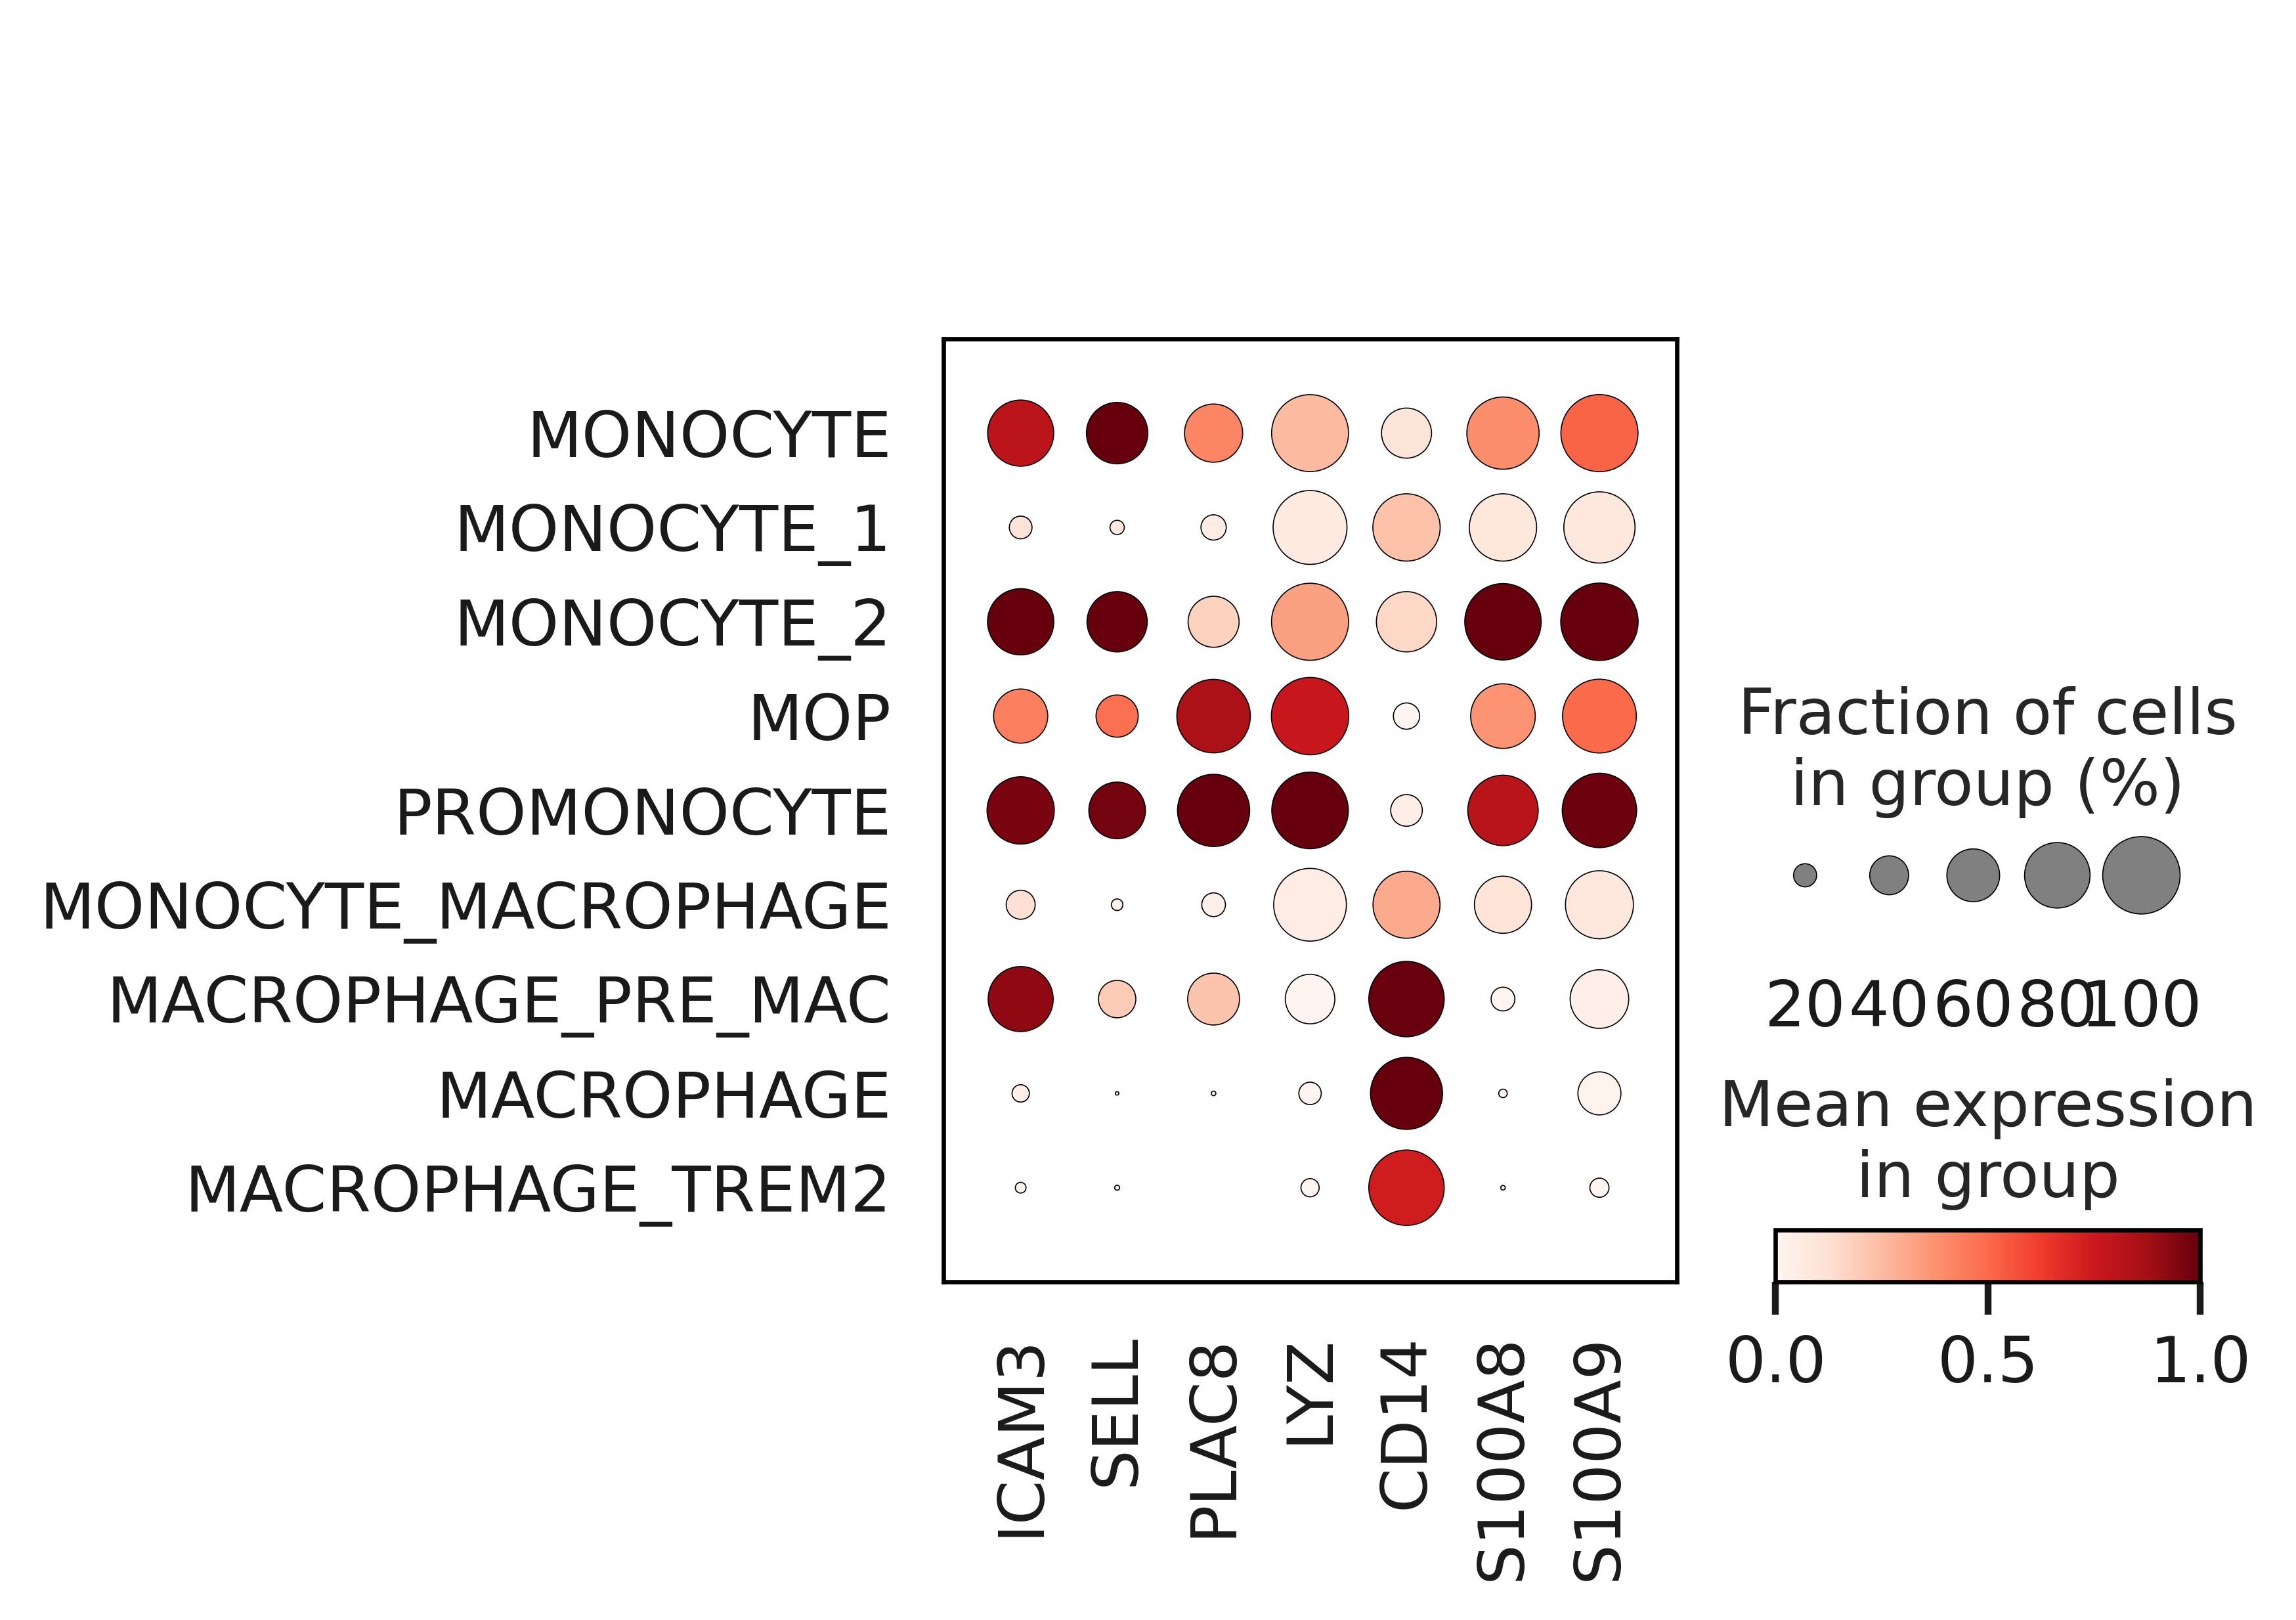

In [144]:
data_temp = adata
markers = markers
spot_var = 'restricted_corr_concat'
(sc.pl.dotplot(data_temp, var_names = markers, groupby='LVL_mono',dendrogram=False,standard_scale='var', color_map='Reds', show = True, save = 'YS_mono_exp.pdf')) # title=i